In [1]:
import numpy as np
import pandas as pd
import gzip
import pickle
from collections import Counter
from utils import split_all_data
from scipy.stats import skew, kurtosis

import re
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
# if you dont have the model uncomment the line below
#!python -m spacy download en_core_web_lg

In [3]:
RANDOM_SEED = 1835

In [4]:
spacy_model = spacy.load('en_core_web_lg')

def spacy_tokenizer(text):
    sp_text = spacy_model(text)
    tokens = [token.lemma_ for token in sp_text if (not token.is_stop and token.is_alpha)]
    return tokens

In [5]:
stop_words = stopwords.words('english')

stemmer = PorterStemmer()
def stem_token(text):
    tokens = [stemmer.stem(word) for word in re.findall(r'\w\w+', text) if word not in stop_words]
    return tokens

In [6]:
data_dict = split_all_data(.8, random_state=RANDOM_SEED)
train_df = data_dict['train']

Loading the data...
Splitting the data...


In [7]:
%%timeit
spacy_tokenizer(train_df['tweet'].iloc[10][0])

25.6 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
stem_token(train_df['tweet'].iloc[10][0])

1.03 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
# testing the tokenizer/lemmatizer
for item in train_df.sample(10, random_state=RANDOM_SEED).itertuples():
    if item[3] is not None:
        tokenized_s = stem_token(item[3][0])
        tokenized_l = spacy_tokenizer(item[3][0])
        count_stem = Counter(tokenized_s)
        count_lemm = Counter(tokenized_l)
        print(f'user: {item[1]} - label: {item[-1]}\n', 'Stemming:     ', count_stem.most_common(10), '\n', 'Lemmatization:', count_lemm.most_common(10), '\n')
    else:
        pass

user: 1290597237991575552 - label: 1
 Stemming:      [('no', 1), ('question', 1), ('de', 1), ('jong', 1), ('bloke', 1), ('worst', 1), ('striker', 1), ('ever', 1), ('seen', 1), ('life', 1)] 
 Lemmatization: [('question', 1), ('De', 1), ('Jong', 1), ('bloke', 1), ('bad', 1), ('striker', 1), ('see', 1), ('life', 1), ('score', 1), ('winner', 1)] 

user: 159535879 - label: 0
 Stemming:      [('rt', 1), ('sadwrit', 1), ('http', 1), ('co', 1), ('ibdvhk7ayt', 1)] 
 Lemmatization: [('RT', 1)] 

user: 22189352 - label: 0
 Stemming:      [('fire', 2), ('final', 1), ('no', 1), ('injuri', 1), ('ff', 1), ('civilian', 1), ('occup', 1), ('displac', 1), ('due', 1), ('caus', 1)] 
 Lemmatization: [('fire', 2), ('FINAL', 1), ('injury', 1), ('FF', 1), ('civilian', 1), ('occupant', 1), ('displace', 1), ('cause', 1), ('investigation', 1)] 

user: 2637583066 - label: 1
 Stemming:      [('5g06021008', 1), ('efiaodo1', 1), ('you', 1), ('right', 1), ('lol', 1), ('swear', 1)] 
 Lemmatization: [('right', 1), ('lol

In [10]:
def extract_topic_feature(row, components=None, tokenizer=None, random_state=None):
    if components is None:
        components = len(row)
    if row is not None and components > 1:
        tweets = np.array(row)

        vectorize = TfidfVectorizer(tokenizer=tokenizer, 
                                    ngram_range=(1, 2),
                                    stop_words=None if tokenizer is not None else 'english',
                                    min_df=1)
        nmf_model = NMF(n_components=components, 
                        init='nndsvd', 
                        max_iter=200, 
                        random_state=random_state)

        
        nmf_pipe = make_pipeline(vectorize, nmf_model)
        
        try:
            W = nmf_pipe.fit_transform(tweets)
        except ValueError:
            return np.nan
        
        index_max = []
        for index in range(W.shape[0]):
            max_val_index = np.argmax(W[index])
            index_max.append(max_val_index)
            
        index_norm = np.array(index_max) / components
        
        return index_norm
    else:
        return np.nan

In [11]:
# unweighted gini coefficient measure taken from https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python by user Gaëtan de Menten
def gini(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(sorted_x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

ID: 1290597237991575552 - Label 1 - number of tweets 17


,only stopword removal,with stemming,with lemmatization
skewness,0.0,0.0,0.052751
kurtosis,-1.208333,-1.208333,-1.258479
standard deviation,0.288175,0.288175,0.282807
gini coefficient,0.352941,0.352941,0.392157


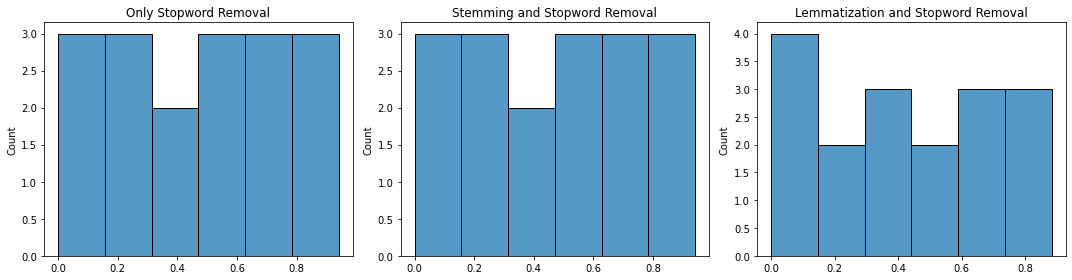

ID: 159535879 - Label 0 - number of tweets 194


,only stopword removal,with stemming,with lemmatization
skewness,0.00354,0.00222,0.068263
kurtosis,-1.249807,-1.225339,-1.253147
standard deviation,0.29344,0.291832,0.284415
gini coefficient,0.344999,0.341308,0.390346


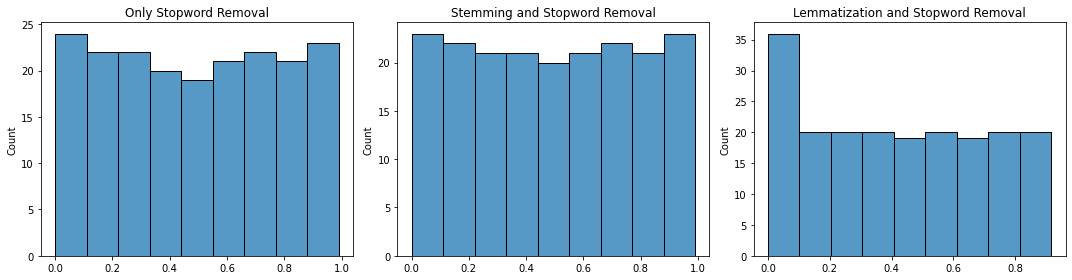

ID: 22189352 - Label 0 - number of tweets 200


,only stopword removal,with stemming,with lemmatization
skewness,-0.029362,-0.026835,-0.003051
kurtosis,-1.240969,-1.199751,-1.213294
standard deviation,0.293502,0.290632,0.290084
gini coefficient,0.338383,0.335632,0.344666


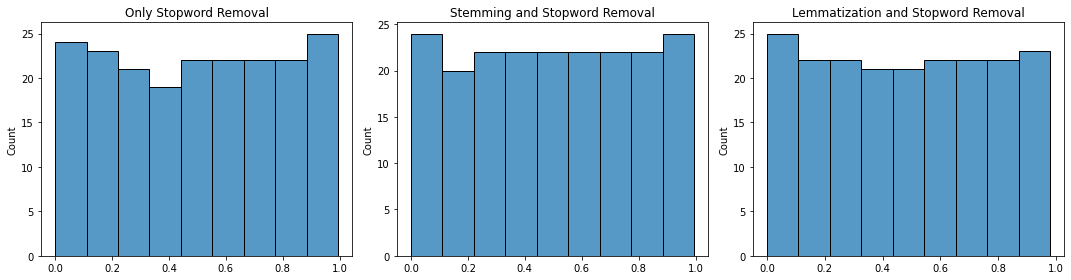

ID: 2637583066 - Label 1 - number of tweets 200


,only stopword removal,with stemming,with lemmatization
skewness,0.016353,-0.009418,0.22109
kurtosis,-1.249725,-1.202875,-1.22444
standard deviation,0.290178,0.28903,0.263253
gini coefficient,0.351371,0.347256,0.442255


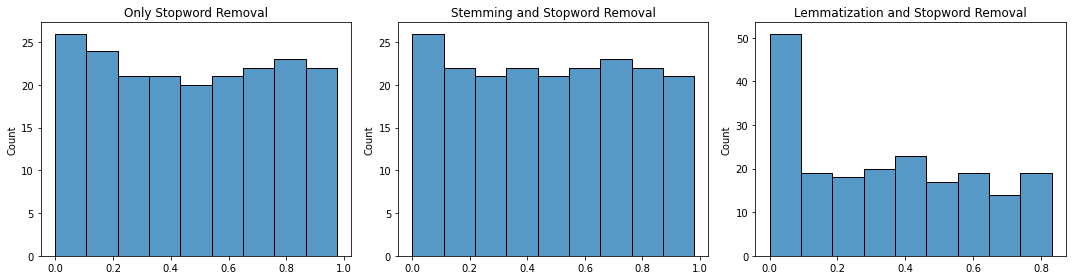

ID: 979469572494495744 - Label 0 - number of tweets 200


,only stopword removal,with stemming,with lemmatization
skewness,0.012655,-0.008513,0.020694
kurtosis,-1.216111,-1.217776,-1.273407
standard deviation,0.290481,0.29315,0.291882
gini coefficient,0.344329,0.347553,0.376312


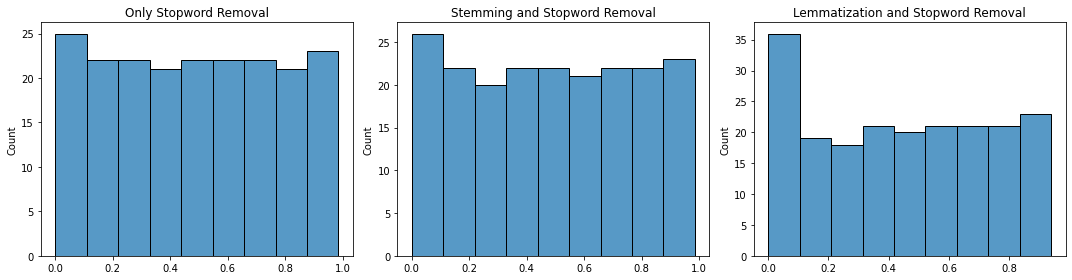

In [12]:


for row in train_df.sample(5, random_state=RANDOM_SEED).itertuples():
    print(f"ID: {row[1]} - Label {row[-1]} - number of tweets {len(row[3])}")
    ind0 = extract_topic_feature(row[3])
    ind1 = extract_topic_feature(row[3], tokenizer=stem_token)
    ind2 = extract_topic_feature(row[3], tokenizer=spacy_tokenizer)
    temp_df = pd.DataFrame(index=['skewness', 'kurtosis', 'standard deviation', 'gini coefficient'], columns=['only stopword removal', 'with stemming', 'with lemmatization'])

    temp_df.loc['skewness', 'only stopword removal'] = skew(ind0)
    temp_df.loc['skewness', 'with stemming'] = skew(ind1)
    temp_df.loc['skewness', 'with lemmatization'] = skew(ind2)
    

    temp_df.loc['kurtosis', 'only stopword removal'] = kurtosis(ind0)
    temp_df.loc['kurtosis', 'with stemming'] = kurtosis(ind1)
    temp_df.loc['kurtosis', 'with lemmatization'] = kurtosis(ind2)

    temp_df.loc['standard deviation', 'only stopword removal'] = ind0.std()
    temp_df.loc['standard deviation', 'with stemming'] = ind1.std()
    temp_df.loc['standard deviation', 'with lemmatization'] = ind2.std()

    temp_df.loc['gini coefficient', 'only stopword removal'] = gini(ind0)
    temp_df.loc['gini coefficient', 'with stemming'] = gini(ind1)
    temp_df.loc['gini coefficient', 'with lemmatization'] = gini(ind2)
    
    display(temp_df)

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    sns.histplot(ind0, ax=ax[0])
    ax[0].set_title('Only Stopword Removal')
    sns.histplot(ind1, ax=ax[1])
    ax[1].set_title('Stemming and Stopword Removal')
    sns.histplot(ind2, ax=ax[2])
    ax[2].set_title('Lemmatization and Stopword Removal')


    plt.tight_layout()
    plt.show()

In [13]:
def extract_nmf_feature(df, tokenizer=spacy_tokenizer):
    df.loc[:, 'topic_dist'] = df['tweet'].apply(lambda x: extract_topic_feature(x, tokenizer=tokenizer) if x is not None else np.nan)
    df.loc[:, 'topic_skew'] = df['topic_dist'].apply(lambda x: skew(x) if x is not None else np.nan)
    df.loc[:, 'topic_kurtosis'] = df['topic_dist'].apply(lambda x: kurtosis(x) if x is not None else np.nan)
    df.loc[:, 'topic_gini'] = df['topic_dist'].apply(lambda x: gini(x) if x is not None else np.nan)
    df.loc[:, 'topic_std'] = df['topic_dist'].apply(lambda x: x.std() if x is not None else np.nan)
    return df

In [14]:
%%time
with_topic_feat = extract_nmf_feature(train_df.sample(10, random_state=RANDOM_SEED))

Wall time: 2min 15s


In [16]:
with_topic_feat[['topic_dist', 'topic_skew', 'topic_kurtosis', 'topic_gini', 'std', 'label']]

,topic_dist,topic_skew,topic_kurtosis,topic_gini,std,label
10139,"[0.23529411764705882, 0.5294117647058824, 0.0,...",0.052751,-1.258479,0.392157,0.282807,1
4587,"[0.0, 0.39690721649484534, 0.6030927835051546,...",0.068263,-1.253147,0.390346,0.284415,0
11274,"[0.885, 0.205, 0.245, 0.295, 0.445, 0.83, 0.43...",-0.003051,-1.213294,0.344666,0.290084,0
1244,"[0.75, 0.495, 0.0, 0.125, 0.32, 0.765, 0.205, ...",0.250567,-1.133643,0.438514,0.254633,1
3949,"[0.805, 0.12, 0.71, 0.49, 0.675, 0.465, 0.425,...",0.034249,-1.265802,0.375551,0.289499,0
7742,"[0.6598984771573604, 0.751269035532995, 0.6548...",-0.023042,-1.270329,0.367377,0.295222,0
2018,"[0.5555555555555556, 0.2638888888888889, 0.618...",-0.021099,-1.250706,0.352752,0.294053,1
2682,"[0.8369565217391305, 0.358695652173913, 0.4673...",0.000434,-1.256409,0.377613,0.284644,0
9994,"[0.59, 0.24, 0.745, 0.25, 0.12, 0.75, 0.2, 0.8...",0.017513,-1.271828,0.367750,0.292317,1
10884,"[0.365, 0.61, 0.47, 0.3, 0.81, 0.845, 0.695, 0...",0.017212,-1.250775,0.366357,0.289363,0
